In [12]:
#From: https://cloud.google.com/speech/docs/streaming-recognize#speech-streaming-recognize-python


import pyaudio
import queue
# [END import_libraries]

# Audio recording parameters
RATE = 16000
CHUNK = int(RATE * 3)  # 3 sec chunks

class MicrophoneStream(object):
    """Opens a recording stream as a generator yielding the audio chunks."""
    def __init__(self, rate, chunk):
        self._rate = rate
        self._chunk = chunk

        # Create a thread-safe buffer of audio data
        self._buff = queue.Queue()
        self.closed = True

    def __enter__(self):
        self._audio_interface = pyaudio.PyAudio()
        self._audio_stream = self._audio_interface.open(
            format=pyaudio.paInt16,
            channels=1, rate=self._rate,
            input=True, frames_per_buffer=self._chunk,
            # Run the audio stream asynchronously to fill the buffer object.
            # This is necessary so that the input device's buffer doesn't
            # overflow while the calling thread makes network requests, etc.
            stream_callback=self._fill_buffer,
        )

        self.closed = False

        return self

    def __exit__(self, type, value, traceback):
        self._audio_stream.stop_stream()
        self._audio_stream.close()
        self.closed = True
        # Signal the generator to terminate so that the client's
        # streaming_recognize method will not block the process termination.
        self._buff.put(None)
        self._audio_interface.terminate()

    def _fill_buffer(self, in_data, frame_count, time_info, status_flags):
        """Continuously collect data from the audio stream, into the buffer."""
        self._buff.put(in_data)
        return None, pyaudio.paContinue

    def generator(self):
        while not self.closed:
            # Use a blocking get() to ensure there's at least one chunk of
            # data, and stop iteration if the chunk is None, indicating the
            # end of the audio stream.
            chunk = self._buff.get()
            if chunk is None:
                return
            data = [chunk]

            # Now consume whatever other data's still buffered.
            while True:
                try:
                    chunk = self._buff.get(block=False)
                    if chunk is None:
                        return
                    data.append(chunk)
                except queue.Empty:
                    break
            yield b''.join(data)
# [END audio_stream]

In [15]:
import numpy as np
with MicrophoneStream(RATE, CHUNK) as stream:
        audio_generator = stream.generator()
        a = np.frombuffer(next(audio_generator),dtype=np.int16)

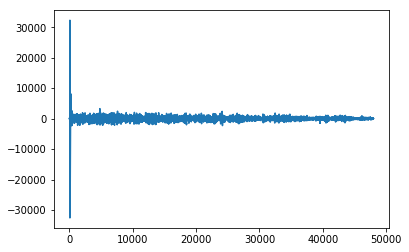

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(a)